Get data

In [13]:
# define rmsle model evaluation function

def rmsle(y_true: pd.Series, y_pred:pd.Series):
    return (((np.log1p(y_true)-np.log1p(y_pred))**2).mean())**0.5

In [14]:
file_path = "./data/X.csv"
X = pd.read_csv(file_path)

file_path = "./data/y.csv"
y = pd.read_csv(file_path)

# Joining y into X
d = X.set_index('id').join(y.set_index('id'))

# removing redundant/extra columns

d.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0'], inplace = True)

# Adding a BMI column: BMI = kg/m2 where kg is a person's weight in kilograms and m2 is their height in metres squared
d['BMI'] = d['weight']/(d['height']**2)

# clear all null lines
for column in d.columns:
    nulls_mask = d[column].notnull()  # or column_with_nulls.isna()
    d = d[nulls_mask]
    
# changing 'Age' to int
d['Age'] = d['Age'].astype(int)

# removing 'O' Gender values:
d = d[d['Gender'] != 'O']

# rounding 'height' values to 2 decimal points
d['height'] = round(d['height']/0.01)*0.01

# rounding weight feature values to no decimal points
d['weight'] = round(d['weight'],0).astype(int)

# changing Salary type from float to int
d['Salary'] = d['Salary'].astype(int)

# rounding BMI value to 1 decimal point
d['BMI'] = round(d['BMI'],1)

# deal with categorial columns
label_encoder = LabelEncoder()
for column in d.select_dtypes(include=['object']).columns:
    d[column + '_encoded'] = label_encoder.fit_transform(d[column])

In [15]:
d.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Country,Race,height,weight,professionalism,Salary,BMI,Gender_encoded,Education Level_encoded,Job Title_encoded,Country_encoded,Race_encoded
id,,,,,,,,,,,,,,,,,
2477,52,M,bachelor's|degr,back|end|develope,24.0,australi,Asian,1.80,95,1150.0,175966,29.3,1,1,3,0,1
76,52,F,bachelor,operations|manage,23.0,us,White,2.45,87,1100.0,160000,14.6,0,0,95,4,9
64,27,M,bachelor,junior|accountan,2.0,australi,Australian,1.92,57,26.0,35000,15.5,1,0,50,0,2
924,32,M,bachelor,data|analys,11.0,u,Welsh,2.16,61,279.0,195000,13.2,1,0,17,3,8
242,39,F,bachelor,senior|product|manage,11.0,chin,Korean,1.79,72,380.0,120000,22.4,0,0,142,2,6


In [16]:
# # iterating through all unique values to identify annomalies
# for column in d.columns:
#     print([column, d[column].sort_values().unique()])

In [17]:
# Examining how log(Salary) vs. BMI and Gender looks on a scatter plot
d['log_Salary'] = np.log(d.Salary)

# all_feature names with no redundancy
all_features = ['Age', 'Years of Experience','professionalism', 'Salary','log_Salary','BMI', 'Gender_encoded', 'Education Level_encoded', 'Job Title_encoded','Country_encoded', 'Race_encoded']

# storing a df that will be used as input for DecisionTreeRegressor to create the 'feature_importance' output
d2 = d[all_features]

X = d2.drop(columns = ['Salary','log_Salary'])
y = d2.Salary

# split the datasets to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [18]:
# sns.scatterplot(data = d,x= 'BMI', y = 'log_Salary', hue = 'Gender', alpha = 0.7).set(ylim = (9,13))

Text(0, 0.5, 'rmsle')

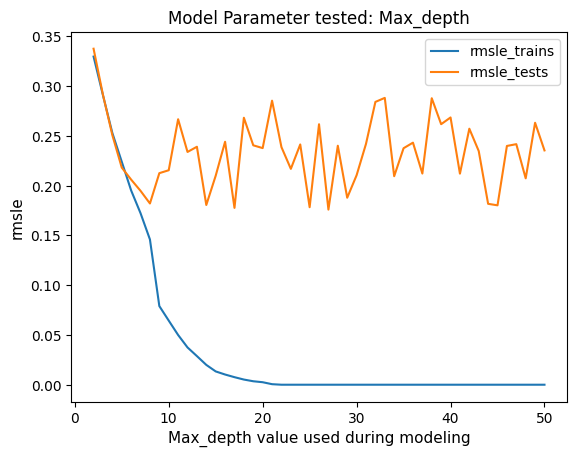

In [19]:
##############################################################################################
# Running Decision Tree Regressor, to assess impact of Max_depth on prediction rmsle (on test)
##############################################################################################

max_depth_range = list(range(2,50+1,1))
max_depth_vals, rmsle_trains, rmsle_tests = [],[],[]

for val in max_depth_range:
  # instantiate class object
  dtr = DecisionTreeRegressor(max_depth = val)

  # fit
  dtr.fit(X_train, y_train)

  # predict
  y_pred_train_dtr = dtr.predict(X_train)
  y_pred_test_dtr = dtr.predict(X_test)

  # score
  dtr_train_rmsle = rmsle(y_train, y_pred_train_dtr)
  dtr_test_rmsle = rmsle(y_test, y_pred_test_dtr)
    
  max_depth_vals.append(val)
  rmsle_trains.append(dtr_train_rmsle)
  rmsle_tests.append(dtr_test_rmsle)

dtr_df = pd.DataFrame(data = {'rmsle_trains': rmsle_trains,
                              'rmsle_tests':rmsle_tests}, 
                              index = max_depth_vals) 
dtr_df.plot()
plt.title('Model Parameter tested: Max_depth')
plt.xlabel('Max_depth value used during modeling', fontsize = 11)
plt.ylabel('rmsle', fontsize = 11)

In [20]:
# dtr_df.rmsle_tests.min().round(5)

(0.0, 0.3)

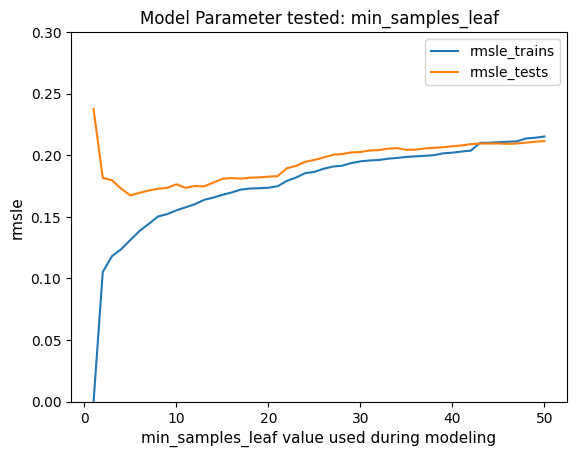

In [21]:
######################################################################################################
# Running Decision Tree Regressor, to assess impact of min_samples_leaf on prediction rmsle (on test)#
######################################################################################################

min_samples_leaf = list(range(1,50+1,1))
min_smp_leafs, rmsle_trains, rmsle_tests = [],[],[]

for val in min_samples_leaf:
  # instantiate class object
  dtr = DecisionTreeRegressor(min_samples_leaf = val)

  # fit
  dtr.fit(X_train, y_train)

  # predict
  y_pred_train_dtr = dtr.predict(X_train)
  y_pred_test_dtr = dtr.predict(X_test)

  # score
  dtr_train_rmsle = rmsle(y_train, y_pred_train_dtr)
  dtr_test_rmsle = rmsle(y_test, y_pred_test_dtr)
    
  min_smp_leafs.append(val)
  rmsle_trains.append(dtr_train_rmsle)
  rmsle_tests.append(dtr_test_rmsle)

dtr_df = pd.DataFrame(data = {'rmsle_trains': rmsle_trains,
                              'rmsle_tests':rmsle_tests}, 
                              index = min_smp_leafs) 
dtr_df.plot()
plt.title('Model Parameter tested: min_samples_leaf')
plt.xlabel('min_samples_leaf value used during modeling', fontsize = 11)
plt.ylabel('rmsle', fontsize = 11)
plt.ylim(0,0.3)

In [22]:
dtr_df.rmsle_tests.min().round(5)

0.16728

Text(0, 0.5, 'rmsle')

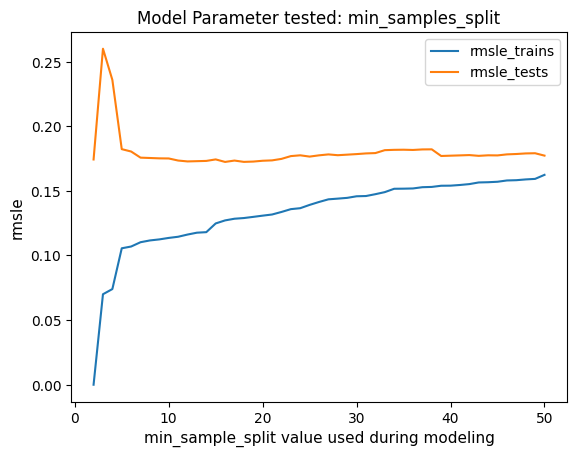

In [23]:
#######################################################################################################
# Running Decision Tree Regressor, to assess impact of min_samples_split on prediction rmsle (on test)#
#######################################################################################################

min_samples_split = list(range(2,50+1))
min_smp_splits, rmsle_trains, rmsle_tests = [],[],[]

for val in min_samples_split:
  # instantiate class object
  dtr = DecisionTreeRegressor(min_samples_split = val)

  # fit
  dtr.fit(X_train, y_train)

  # predict
  y_pred_train_dtr = dtr.predict(X_train)
  y_pred_test_dtr = dtr.predict(X_test)

  # score
  dtr_train_rmsle = rmsle(y_train, y_pred_train_dtr)
  dtr_test_rmsle = rmsle(y_test, y_pred_test_dtr)
    
  min_smp_splits.append(val)
  rmsle_trains.append(dtr_train_rmsle)
  rmsle_tests.append(dtr_test_rmsle)

dtr_df = pd.DataFrame(data = {'rmsle_trains': rmsle_trains,
                              'rmsle_tests':rmsle_tests}, 
                              index = min_smp_splits) 
dtr_df.plot()
plt.title('Model Parameter tested: min_samples_split')
plt.xlabel('min_sample_split value used during modeling', fontsize = 11)
plt.ylabel('rmsle', fontsize = 11)

In [24]:
# getting DecisionTreeRegressor model's feature_importance_ attribute
importances = list(dtr.fit(X_train, y_train).feature_importances_.round(3))
columns = X_train.columns.values.tolist()
res = []

for column,importance in zip(columns,importances):
    res.append((column, importance))
res.sort(key = lambda x:x[1], reverse = True)
print(res)

# creating a df so that features will appear in a 'table' view, sorted by importance and numbered (for ppt)

prt_df = pd.DataFrame({'feature': columns, 'feature_importance': importances})
sorted_prt_df = prt_df.sort_values(by = ['feature_importance'], ascending = False)
sorted_prt_df.reset_index(inplace = True)
sorted_prt_df.index = sorted_prt_df.index + 1
sorted_prt_df.drop(columns = 'index')

# final_df = df.sort_values(by=['2'], ascending=False)

# .sort_values('feature_importance', ascending = False)

[('Years of Experience', 0.699), ('Job Title_encoded', 0.117), ('professionalism', 0.093), ('Education Level_encoded', 0.056), ('Age', 0.033), ('Gender_encoded', 0.001), ('BMI', 0.0), ('Country_encoded', 0.0), ('Race_encoded', 0.0)]


,feature,feature_importance
1,Years of Experience,0.699
2,Job Title_encoded,0.117
3,professionalism,0.093
4,Education Level_encoded,0.056
5,Age,0.033
6,Gender_encoded,0.001
7,BMI,0.000
8,Country_encoded,0.000
9,Race_encoded,0.000


In [25]:
# extracting the list of features based on their decision tree importance
features_by_dtr_importance = [res[i][0] for i in range(len(res))]
features_by_dtr_importance

['Years of Experience',
 'Job Title_encoded',
 'professionalism',
 'Education Level_encoded',
 'Age',
 'Gender_encoded',
 'BMI',
 'Country_encoded',
 'Race_encoded']

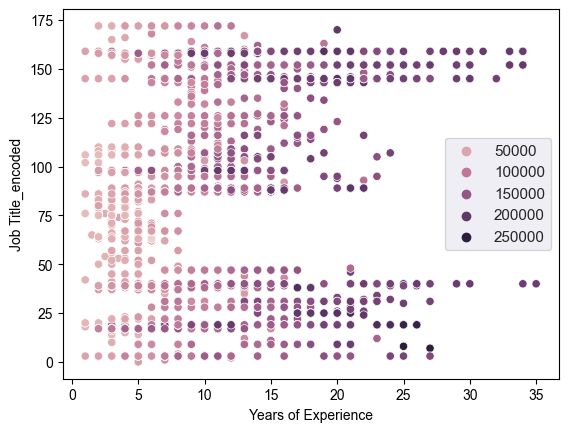

In [26]:
# plotting the most tree-based important features with hue = 'Salary'
sns.scatterplot(data = X_train.join(y_train),x= 'Years of Experience', y = 'Job Title_encoded', hue = 'Salary')
sns.set(rc={'figure.figsize':(6,6)})

plt.legend(loc = 'center right')

In [27]:
# reordering columns df by dtr-based feature importance
d3 = d2[features_by_dtr_importance]

In [28]:
from sklearn.metrics import mean_squared_error as mse

def my_fit(X,y):
  X=X.join(y)
  model2 = X.groupby('group_number')[y.name].mean()
  return model2

def my_predict(X,model2):
  y_pred2 = X.group_number.map(model2)
  return y_pred2

def rmsle(y_true: pd.Series, y_pred:pd.Series):
    return (((np.log1p(y_true)-np.log1p(y_pred))**2).mean())**0.5

C:\Users\user\AppData\Local\Temp\ipykernel_20184\2046331569.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()


5343
per train data, model's rmse based on ['Years of Experience'] is: 27264.0
per train data, model's rmsle based on ['Years of Experience'] is: 0.30089


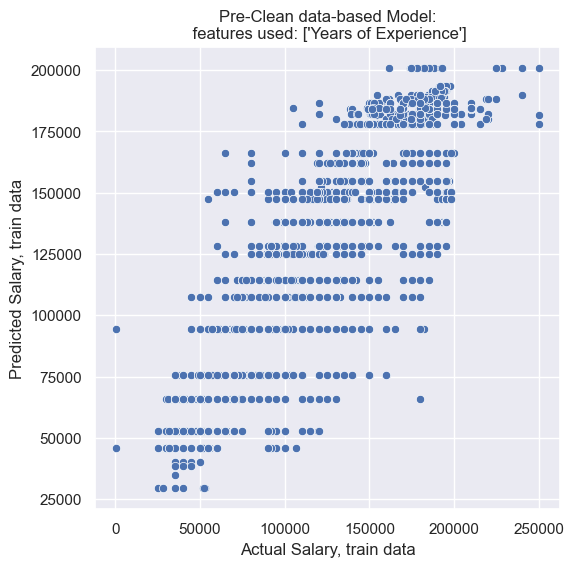



5343
per train data, model's rmse based on ['Years of Experience', 'Job Title_encoded'] is: 12922.0
per train data, model's rmsle based on ['Years of Experience', 'Job Title_encoded'] is: 0.15565


C:\Users\user\AppData\Local\Temp\ipykernel_20184\2046331569.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()


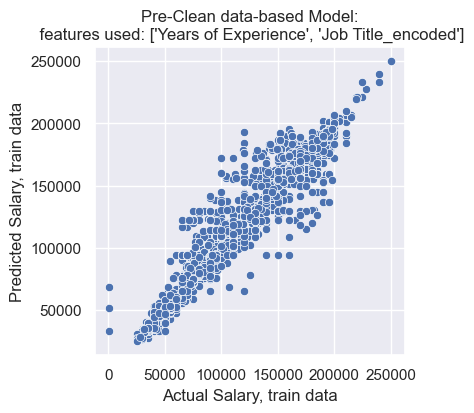



5343
per train data, model's rmse based on ['Years of Experience', 'Job Title_encoded', 'professionalism'] is: 5267.0
per train data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism'] is: 0.09713


C:\Users\user\AppData\Local\Temp\ipykernel_20184\2046331569.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()


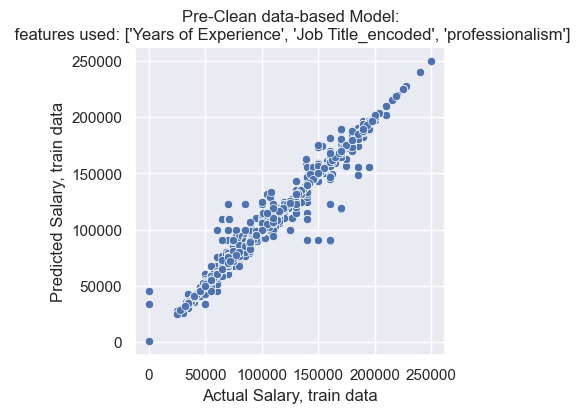



5343
per train data, model's rmse based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded'] is: 3197.0
per train data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded'] is: 0.08883


C:\Users\user\AppData\Local\Temp\ipykernel_20184\2046331569.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()


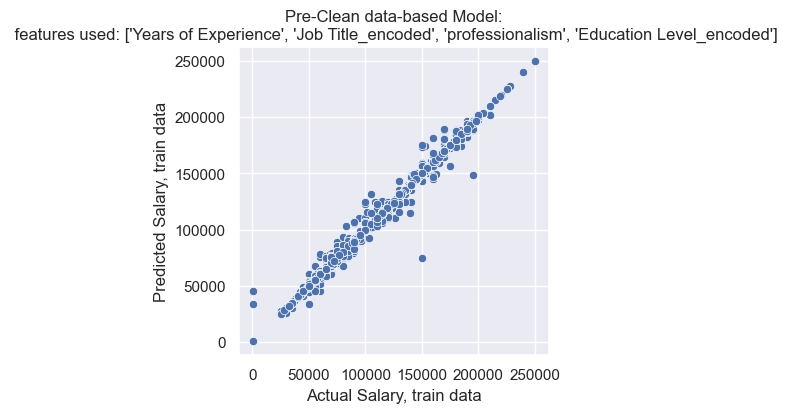



5343
per train data, model's rmse based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age'] is: 2961.0
per train data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age'] is: 0.08506


C:\Users\user\AppData\Local\Temp\ipykernel_20184\2046331569.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()


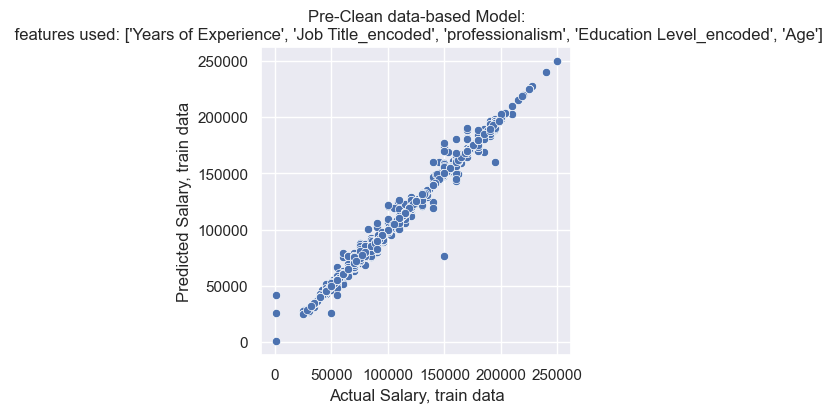



5343
per train data, model's rmse based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age', 'Gender_encoded'] is: 2251.0
per train data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age', 'Gender_encoded'] is: 0.08289


C:\Users\user\AppData\Local\Temp\ipykernel_20184\2046331569.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()


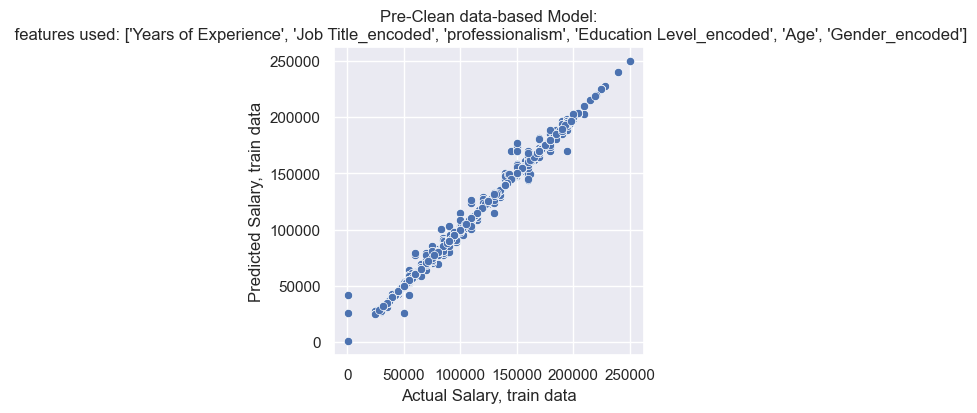



5343
per train data, model's rmse based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age', 'Gender_encoded', 'BMI'] is: 367.0
per train data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age', 'Gender_encoded', 'BMI'] is: 0.00369


C:\Users\user\AppData\Local\Temp\ipykernel_20184\2046331569.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()


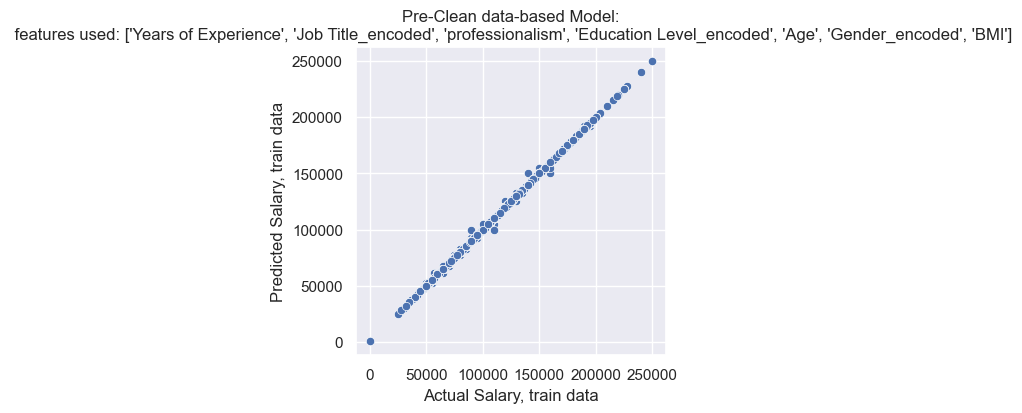



5343
per train data, model's rmse based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age', 'Gender_encoded', 'BMI', 'Country_encoded'] is: 199.0
per train data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age', 'Gender_encoded', 'BMI', 'Country_encoded'] is: 0.00201


C:\Users\user\AppData\Local\Temp\ipykernel_20184\2046331569.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()


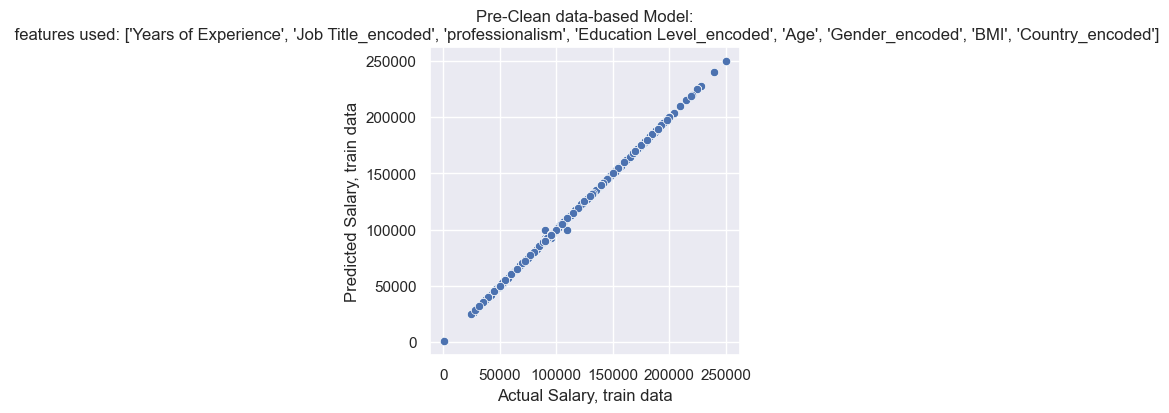

In [29]:
# testing performance of a group-by.mean() custom model
# No test_train_split step is done here to maximize model performance on task's REAL X_test dataset
# redefining X and y
X = d3
y = d2.Salary

for i in range(1,len(X.columns.values)):
    
  # itterate over tested feature combinations
  features = list(X.columns[:i].values)
  # features = ['Country_encoded', 'Race_encoded']

  # create an X Series grouped by chosen features; each unique feature combination is group-numbered
  X['group_number'] = X.groupby(features).ngroup()

#   # split the datasets to train and test
#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  # create a model per selected features using train data
  # model = my_fit(X_train,y_train)
  model = my_fit(X,y)

  # predict y (price) per X_test and model
  # y_pred_train = my_predict(X_train, model)  
  # y_pred_test = my_predict(X_test, model)
  # print(y_pred_test.loc[~y_pred_test.isnull()].size)
    
  y_pred_train = my_predict(X, model)  
  # y_pred_test = my_predict(X, model)
  print(y_pred_train.loc[~y_pred_train.isnull()].size)

  # # calc & print model's rmsle
  # rmsle_train = rmsle(y_train,y_pred_train)
  # rmsle_test = rmsle(y_test,y_pred_test)
  rmsle_train = rmsle(y,y_pred_train)
  rmse_train = np.sqrt(mse(y, y_pred_train))

  print(f"per train data, model's rmse based on {features} is: {rmse_train.round(0)}")
  print(f"per train data, model's rmsle based on {features} is: {rmsle_train.round(5)}")
  # print(f"per test data, model's rmsle based on {features} is: {rmsle_test.round(5)}\n")

  # plot
  fig, ax = plt.subplots()
  sns.scatterplot(x = y.values, y = y_pred_train.values)
  sns.set(rc={'figure.figsize':(4,4)})
  plt.title(f"Pre-Clean data-based Model:\n features used: {features}")
  plt.xlabel('Actual Salary, train data')
  plt.ylabel('Predicted Salary, train data')
  plt.show()
  print('\n')

In [30]:
# Making sure there are no Nulls
# y_pred_train.sort_values().unique()

In [31]:
# file_path = "./data/X_test.csv"
# task_X_test = pd.read_csv(file_path)

# task_X_test.info()

In [32]:
###############################################################################################################
# Getting the REAL X_test (with currently unknown y actual values) through the same data transformation steps #
###############################################################################################################

file_path = "./data/X_test.csv"
task_X_test = pd.read_csv(file_path)

# task_X_test.info()

# setting 'id' column as index
task_X_test.set_index('id', inplace = True)

# removing redundant/extra columns

task_X_test.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0'], inplace = True)

# # Adding a BMI column: BMI = kg/m2 where kg is a person's weight in kilograms and m2 is their height in metres squared
task_X_test['BMI'] = task_X_test['weight']/(task_X_test['height']**2)

# clear all null lines
for column in task_X_test.columns:
    nulls_mask = task_X_test[column].notnull()  # or column_with_nulls.isna()
    task_X_test = task_X_test[nulls_mask]
    
# changing 'Age' to int
task_X_test['Age'] = task_X_test['Age'].astype(int)

# Removing the 'O' gender rows (2)
task_X_test = task_X_test.loc[task_X_test['Gender'] != 'O']

# rounding 'height' values to 2 decimal points
task_X_test['height'] = round(task_X_test['height']/0.01)*0.01

# rounding weight feature values to no decimal points
task_X_test['weight'] = round(task_X_test['weight'],0).astype(int)

# rounding BMI value to 1 decimal point
task_X_test['BMI'] = round(task_X_test['BMI'],1)

# deal with categorial columns
label_encoder = LabelEncoder()
for column in task_X_test.select_dtypes(include=['object']).columns:
    task_X_test[column + '_encoded'] = label_encoder.fit_transform(task_X_test[column])
    
# Re-Ordering the df features by 'feature_importance' reported by the DecisionTreeRegressor algo
task_X_test = task_X_test[features_by_dtr_importance]

In [33]:
# testing performance of a group-by.mean() custom model on this Task's X_test dataset

for i in range(1,len(task_X_test.columns.values)):
    
  # itterate over tested feature combinations
  features = list(task_X_test.columns[:i].values)

  # create an X Series grouped by chosen features; each unique feature combination is group-numbered
  task_X_test['group_number'] = task_X_test.groupby(features).ngroup()

#   # split the datasets to train and test
#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  # create a model per selected features using train data
  # model = my_fit(X_train,y_train)
  model = my_fit(X,y)

  # predict y (price) per X_test and model
  # y_pred_train = my_predict(X_train, model)  
  # y_pred_test = my_predict(X_test, model)
  # print(y_pred_test.loc[~y_pred_test.isnull()].size)
    
  y_pred_test = my_predict(task_X_test, model)
   
  # print() the number of non-null rows in y_pred
  print(y_pred_test.loc[~y_pred_test.isnull()].size)

# print() the number of rows in a df
print('\n',len(task_X_test.index))

  # # calc & print model's rmsle
  # rmsle_train = rmsle(y_train,y_pred_train)
  # rmsle_test = rmsle(y_test,y_pred_test)
  # rmsle_train = rmsle(y,y_pred_train)


  # print(f"per train data, model's rmsle based on {features} is: {rmsle_train.round(3)}")
  # print(f"per test data, model's rmsle based on {features} is: {rmsle_test.round(3)}\n")

  # # plot
  # fig, ax = plt.subplots()
  # sns.scatterplot(x = y.values, y = y_pred_train.values)
  # sns.set(rc={'figure.figsize':(4,4)})
  # plt.title(f"Pre-Clean data-based Model:\n features used: {features}")
  # plt.xlabel('Actual Salary, test data')
  # plt.ylabel('Predicted Salary, test data')
  # plt.show()
  # print('\n')

1339
1339
1339
1339
1339
1339
1339
1339

 1339


In [34]:
# # Making sure there are No Missing Values in y_test_pred
# y_pred_test.sort_values().unique()
# y_pred_test.isnull().sum()

# list(range(1,9))
X.columns.values.tolist()

['Years of Experience',
 'Job Title_encoded',
 'professionalism',
 'Education Level_encoded',
 'Age',
 'Gender_encoded',
 'BMI',
 'Country_encoded',
 'Race_encoded',
 'group_number']

In [35]:
# dict([(i, X.columns[:i].values.tolist()) for i in range(1,len(X.columns[:-1].values.tolist()))])
# X.columns.values.tolist()


# pd.DataFrame({'features': all_features, 'feature #': list(range(1,9+1))})

1602
per train data, model's rmsle based on ['Years of Experience'] is: 0.29896
per test data, model's rmsle based on ['Years of Experience'] is: 0.30738
The [rmsle_test/rmsle_train] ratio = 1.03



C:\Users\user\AppData\Local\Temp\ipykernel_20184\2120692070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()


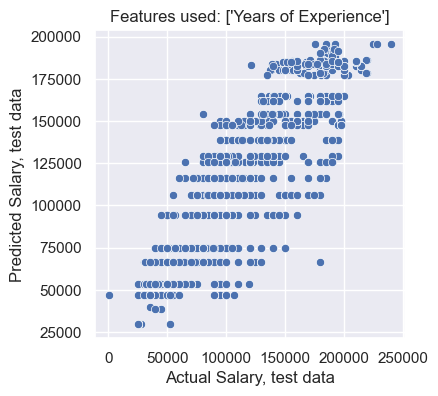



1523
per train data, model's rmsle based on ['Years of Experience', 'Job Title_encoded'] is: 0.15027
per test data, model's rmsle based on ['Years of Experience', 'Job Title_encoded'] is: 0.18011
The [rmsle_test/rmsle_train] ratio = 1.20



C:\Users\user\AppData\Local\Temp\ipykernel_20184\2120692070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()


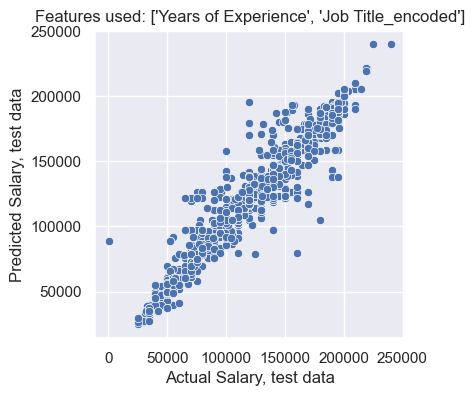



1287
per train data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism'] is: 0.10929
per test data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism'] is: 0.07145
The [rmsle_test/rmsle_train] ratio = 0.65



C:\Users\user\AppData\Local\Temp\ipykernel_20184\2120692070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()


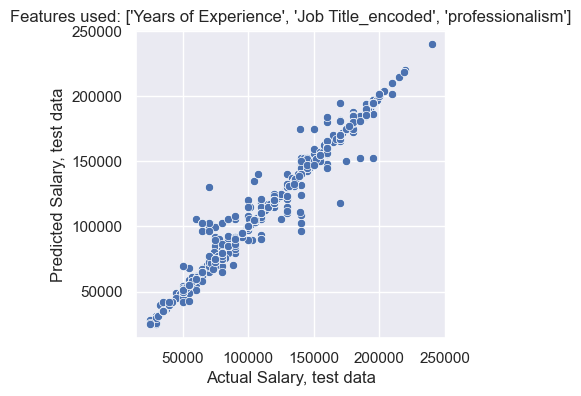



1252
per train data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded'] is: 0.10349
per test data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded'] is: 0.04363
The [rmsle_test/rmsle_train] ratio = 0.42



C:\Users\user\AppData\Local\Temp\ipykernel_20184\2120692070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()


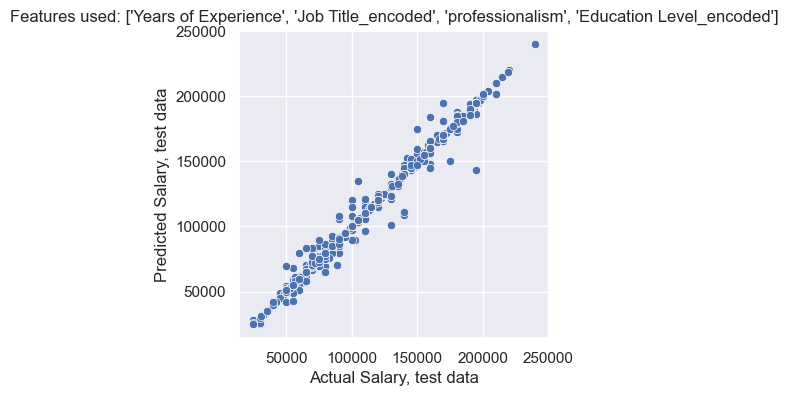



1072
per train data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age'] is: 0.0985
per test data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age'] is: 0.04782
The [rmsle_test/rmsle_train] ratio = 0.49



C:\Users\user\AppData\Local\Temp\ipykernel_20184\2120692070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()


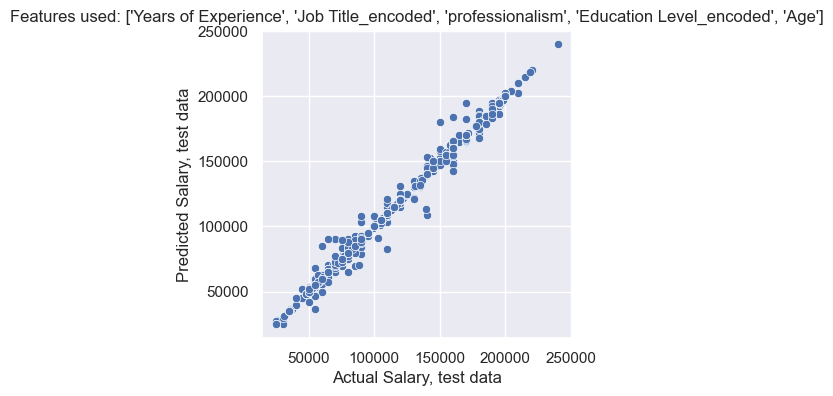



1030
per train data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age', 'Gender_encoded'] is: 0.09659
per test data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age', 'Gender_encoded'] is: 0.03713
The [rmsle_test/rmsle_train] ratio = 0.38



C:\Users\user\AppData\Local\Temp\ipykernel_20184\2120692070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()


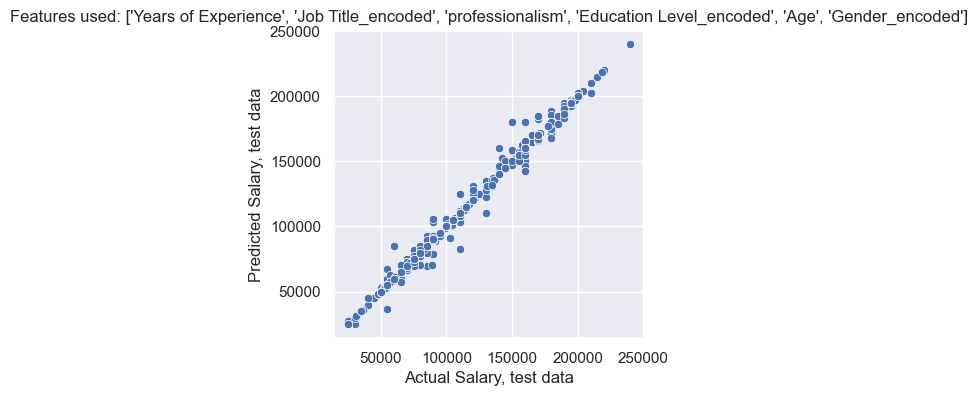



19
per train data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age', 'Gender_encoded', 'BMI'] is: 0.00309
per test data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age', 'Gender_encoded', 'BMI'] is: 0.05644
The [rmsle_test/rmsle_train] ratio = 18.27



C:\Users\user\AppData\Local\Temp\ipykernel_20184\2120692070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()


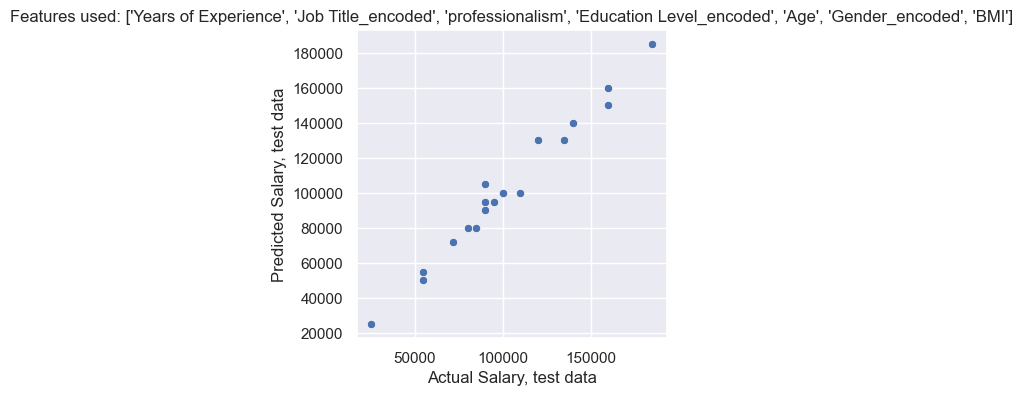



4
per train data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age', 'Gender_encoded', 'BMI', 'Country_encoded'] is: 0.0
per test data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age', 'Gender_encoded', 'BMI', 'Country_encoded'] is: 0.10391
The [rmsle_test/rmsle_train] ratio = inf



C:\Users\user\AppData\Local\Temp\ipykernel_20184\2120692070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()
C:\Users\user\AppData\Local\Temp\ipykernel_20184\2120692070.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"The [rmsle_test/rmsle_train] ratio = {rmsle_test/rmsle_train:.2f}\n")
C:\Users\user\AppData\Local\Temp\ipykernel_20184\2120692070.py:57: RuntimeWarning: divide by zero encountered in scalar divide
  rmsle_test_train_ratio.append(f"{rmsle_test/rmsle_train:.2f}")


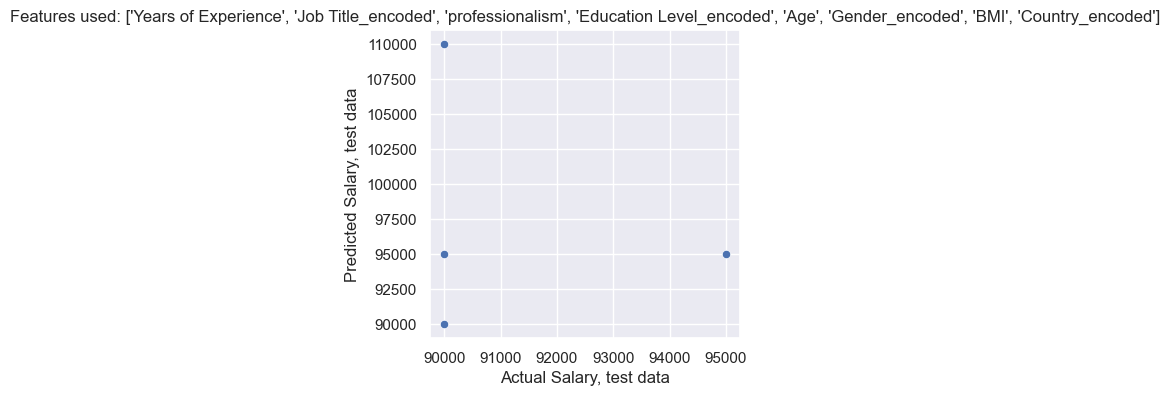



1
per train data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age', 'Gender_encoded', 'BMI', 'Country_encoded', 'Race_encoded'] is: 0.0
per test data, model's rmsle based on ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age', 'Gender_encoded', 'BMI', 'Country_encoded', 'Race_encoded'] is: 0.20067
The [rmsle_test/rmsle_train] ratio = inf



C:\Users\user\AppData\Local\Temp\ipykernel_20184\2120692070.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(features).ngroup()
C:\Users\user\AppData\Local\Temp\ipykernel_20184\2120692070.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"The [rmsle_test/rmsle_train] ratio = {rmsle_test/rmsle_train:.2f}\n")
C:\Users\user\AppData\Local\Temp\ipykernel_20184\2120692070.py:57: RuntimeWarning: divide by zero encountered in scalar divide
  rmsle_test_train_ratio.append(f"{rmsle_test/rmsle_train:.2f}")


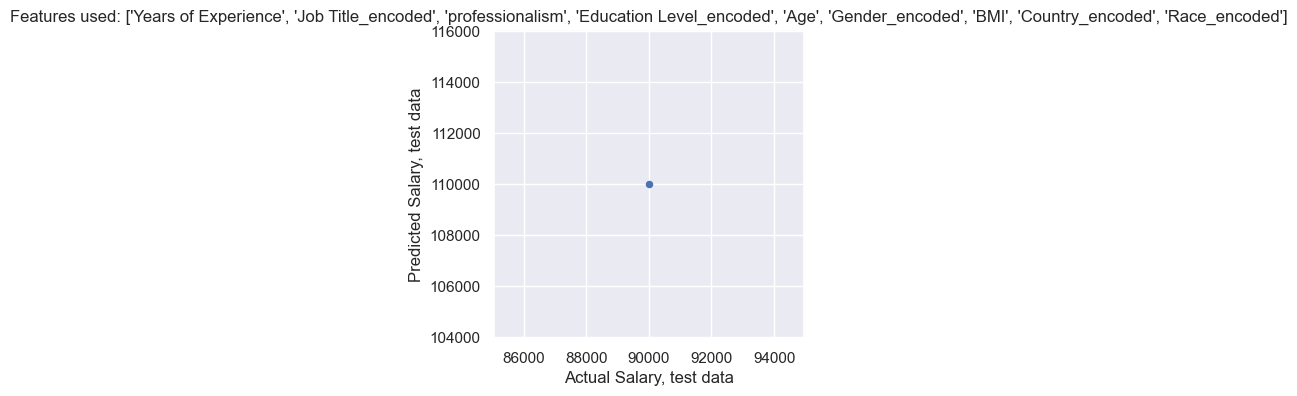

In [53]:
#######################################################################################################
# Repeating training step on 95% of the data to save 5% for test-data model performance estimation ####
#######################################################################################################

# testing performance of a group-by.mean() custom model
# Here I DO test_train_split step to enable testing for model's overfit

# redefining X and y
X = d3
y = d2.Salary

rmsle_test_train_ratio = []
nfeatures = []
rmsle_tests, rmsle_trains = [],[]

for i in range(1,len(X.columns.values)):
    
  # itterate over tested feature combinations
  features = list(X.columns[:i].values)
  # features = ['Country_encoded', 'Race_encoded']

  # create an X Series grouped by chosen features; each unique feature combination is group-numbered
  X['group_number'] = X.groupby(features).ngroup()

  # split the datasets to train and test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  # create a model per selected features using train data
  model = my_fit(X_train,y_train)
  # model = my_fit(X,y)

  # predict y (price) per X_test and model
  y_pred_train = my_predict(X_train, model)  
  y_pred_test = my_predict(X_test, model)
  print(y_pred_test.loc[~y_pred_test.isnull()].count())
    
  # y_pred_train = my_predict(X, model)  
  # # y_pred_test = my_predict(X, model)
  # print(y_pred_train.loc[~y_pred_train.isnull()].size)

  # # calc & print model's rmsle & rmse
  # rmsle_train = rmsle(y_train,y_pred_train)
  # rmsle_test = rmsle(y_test,y_pred_test)
  rmsle_train = rmsle(y_train,y_pred_train)
  rmsle_test = rmsle(y_test,y_pred_test)
  # rmse_train = np.sqrt(mse(y_train, y_pred_train))
  # rmse_test = np.sqrt(mse(y_test, y_pred_test))

  # print(f"per train data, model's rmse based on {features} is: {rmse_train.round(0)}")
  # print(f"per test data, model's rmse based on {features} is: {rmse_test.round(0)}")
  print(f"per train data, model's rmsle based on {features} is: {rmsle_train.round(5)}")
  print(f"per test data, model's rmsle based on {features} is: {rmsle_test.round(5)}")
  print(f"The [rmsle_test/rmsle_train] ratio = {rmsle_test/rmsle_train:.2f}\n")
  # rmsle_test_train_ratio.append(f"{rmsle_test/rmsle_train:.2f}")
  rmsle_tests.append(rmsle_test.round(4))
  rmsle_trains.append(rmsle_train.round(4))
  rmsle_test_train_ratio.append(f"{rmsle_test/rmsle_train:.2f}")
  nfeatures.append(len(features))
    

  # plot
  fig, ax = plt.subplots()
  sns.scatterplot(x = y_test.values, y = y_pred_test.values)
  sns.set(rc={'figure.figsize':(4,4)})
  plt.title(f"Features used: {features}")
  plt.xlabel('Actual Salary, test data')
  plt.ylabel('Predicted Salary, test data')
  plt.show()
  print('\n')

In [56]:
y_pred_test.notnull().sum()

1

Text(0.5, 0, 'number of features used for modeling')

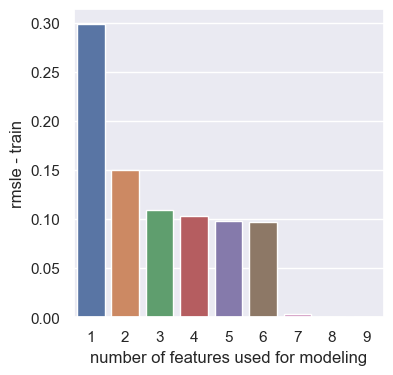

In [37]:
# create a barplot of number of features used vs. rmsle train model scores:
sns.barplot(x = nfeatures,y =  rmsle_trains)
plt.ylabel('rmsle - train')
plt.xlabel('number of features used for modeling')


Text(0.5, 0, 'number of features used for modeling')

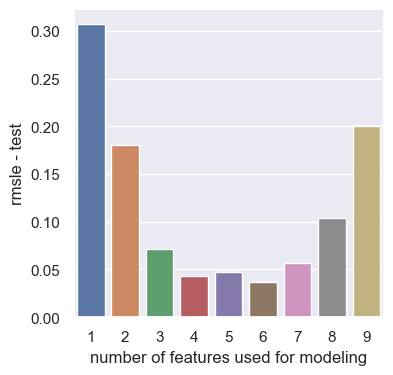

In [38]:
# create a barplot of number of features used vs. rmsle test model scores:
sns.barplot(x = nfeatures,y =  rmsle_tests)
plt.ylabel('rmsle - test')
plt.xlabel('number of features used for modeling')


In [39]:
# Based on the upper analysis the features chosen below yield the minimal rmsle with no model overfit;
# Including any additional feature (out of the following: 'BMI', 'Country_encoded', 'Race_encoded') results in elevated rmse and model overfit 
chosen_model_features = ['Years of Experience', 'Job Title_encoded', 'professionalism', 'Education Level_encoded', 'Age', 'Gender_encoded']

In [40]:
#############################################################################################################################
# Using only the 'chosen_model_features' (see upper cell here) to produce 'Best' y_pred for task's X_test dataset
##############################################################################################################################

# for i in range(1,len(task_X_test.columns.values)):
for i in range(1,2):
    
  # itterate over tested feature combinations
  features = chosen_model_features

  # create an X Series grouped by chosen features; each unique feature combination is group-numbered
  task_X_test['group_number'] = task_X_test.groupby(features).ngroup()

#   # split the datasets to train and test
#   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  # create a model per selected features using train data
  # model = my_fit(X_train,y_train)
  model = my_fit(X,y)

  # predict y (price) per X_test and model
  # y_pred_train = my_predict(X_train, model)  
  # y_pred_test = my_predict(X_test, model)
  # print(y_pred_test.loc[~y_pred_test.isnull()].size)
    
  y_pred_test = my_predict(task_X_test, model)
   
  # print() the number of non-null rows in y_pred
  print(y_pred_test.loc[~y_pred_test.isnull()].size)

# print() the number of rows in a df
print('\n',len(task_X_test.index))

  # # calc & print model's rmsle
  # rmsle_train = rmsle(y_train,y_pred_train)
  # rmsle_test = rmsle(y_test,y_pred_test)
  # rmsle_train = rmsle(y,y_pred_train)


  # print(f"per train data, model's rmsle based on {features} is: {rmsle_train.round(3)}")
  # print(f"per test data, model's rmsle based on {features} is: {rmsle_test.round(3)}\n")

  # # plot
  # fig, ax = plt.subplots()
  # sns.scatterplot(x = y.values, y = y_pred_train.values)
  # sns.set(rc={'figure.figsize':(4,4)})
  # plt.title(f"Pre-Clean data-based Model:\n features used: {features}")
  # plt.xlabel('Actual Salary, test data')
  # plt.ylabel('Predicted Salary, test data')
  # plt.show()
  # print('\n')

1339

 1339


In [41]:
# Making sure there are no Null values in y_pred_test
# y_pred_test.sort_values().unique()
# y_pred_test.isnull().sum()
# y_pred_test.to_dict()

In [42]:
# Verifying indices of tasks_X_test and X are distinct 
# y_pred_test.index.sort_values()
# X['Age'].index.sort_values()

In [43]:
# # testing whether use of all other features (initially neglected) would improve rmsle score

# X2 = data2.drop(columns = ['Salary'])
# y2 = data2.Salary

# from sklearn.metrics import mean_squared_error as mse

# # for i in range(1,len(X2.columns.values)+1):
# # cancelled the upper iteration and prints only feature combination with 'best' rmsle
# for i in range(0,1):
    
#   # itterate over tested feature combinations
#   # features = list(X2.columns[:i].values)
#   features = list(X2.columns[:4].values)
#   # features = ['height_bins', 'weight_bins']

#   # create an X Series grouped by chosen features; each unique feature combination is group-numbered
#   X2['group_number'] = X2.groupby(features).ngroup()

#   # split the datasets to train and test
#   X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

#   # create a model per selected features using train data
#   model2 = my_fit(X2_train,y2_train)

#   # predict y (price) per X_test and model2
#   y_pred2_train = my_predict(X2_train, model2)  
#   y_pred2_test = my_predict(X2_test, model2)

#   # calc & print model's rmsle
#   rmsle2_train = rmsle(y2_train,y_pred2_train)
#   rmsle2_test = rmsle(y2_test,y_pred2_test)

#   print(f"per train data, model's rmsle based on {features} is: {rmsle2_train:.3f}")
#   print(f"per test data, model's rmsle based on {features} is: {rmsle2_test:.3f}")

#   # plot
#   fig, ax = plt.subplots()
#   sns.scatterplot(x = y2_test.values, y = y_pred2_test.values)
#   plt.title(f"Clean data-based Model:\n features used: {features}")
#   plt.xlabel('Actual Salary, test data')
#   plt.ylabel('Predicted Salary, test data')
#   plt.show()
#   print('\n')

In [44]:
# # Validating that this upper finding is random-state-proof

# # custom groupby-based step-wise model, using CLEAN data (data2)

# X3 = data2.drop(columns = 'Salary')
# y3 = data2.Salary

# for i in range(1,len(X2.columns.values)+1):
    
#   # itterate over tested feature combinations
#   features = list(X2.columns[:i].values)
#   # features = ['Country_encoded', 'Race_encoded']

#   # split the datasets to train and test while ev through different random states
#   X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.33, random_state= np.random.randint(100))

#   # create an X Series grouped by chosen features; each unique feature combination is group-numbered
#   X3['group_number'] = X3.groupby(features).ngroup()

#   # create a model per selected features using train data
#   model3 = my_fit(X3_train,y3_train)

#   # predict y (price) per X_test and model2
#   y_pred3_train = my_predict(X3_train, model3)  
#   y_pred3_test = my_predict(X3_test, model3)

#   # calc & print model's rmsle
#   rmsle3_train = rmsle(y3_train,y_pred3_train)
#   rmsle3_test = rmsle(y3_test,y_pred3_test)

#   # make report
#   report3.append((rmsle2_test.round(3)))
#   # index of minimal value
# result.append(report3.index(min(report3)))
# report3 = []

# print(result)

                 
#   # print(f"per train data, model's rmsle based on {features} is: {rmsle2_train.round(3)}")
#   # print(f"per test data, model's rmsle based on {features} is: {rmsle2_test.round(3)}\n")

Text(0, 0.5, 'rmsle')

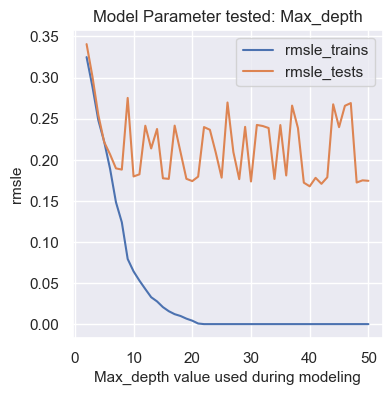

In [45]:
##############################################################################################
# Running Decision Tree Regressor, to assess impact of Max_depth on prediction rmsle (on test)
##############################################################################################

max_depth_range = list(range(2,50+1,1))
max_depth_vals, rmsle_trains, rmsle_tests = [],[],[]

for val in max_depth_range:
  # instantiate class object
  dtr = DecisionTreeRegressor(max_depth = val)

  # fit
  dtr.fit(X_train, y_train)

  # predict
  y_pred_train_dtr = dtr.predict(X_train)
  y_pred_test_dtr = dtr.predict(X_test)

  # score
  dtr_train_rmsle = rmsle(y_train, y_pred_train_dtr)
  dtr_test_rmsle = rmsle(y_test, y_pred_test_dtr)
    
  max_depth_vals.append(val)
  rmsle_trains.append(dtr_train_rmsle)
  rmsle_tests.append(dtr_test_rmsle)

dtr_df = pd.DataFrame(data = {'rmsle_trains': rmsle_trains,
                              'rmsle_tests':rmsle_tests}, 
                              index = max_depth_vals) 
dtr_df.plot()
plt.title('Model Parameter tested: Max_depth')
plt.xlabel('Max_depth value used during modeling', fontsize = 11)
plt.ylabel('rmsle', fontsize = 11)

(0.0, 0.2)

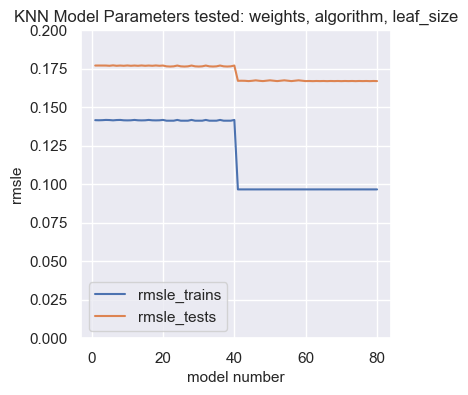

In [46]:
###########################################################################################################
# Running KNN Regression, to assess impact of 3 params (weight, algoritm and leaf_size) on rmsle (on test)#
###########################################################################################################

weights = ['uniform','distance']

leafs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

algos = ['auto', 'ball_tree', 'kd_tree', 'brute']

idx = 0

# max_depth_range = list(range(2,50+1,1))
indices, rmsle_trains, rmsle_tests = [],[],[]

report = []

for weight in weights:
    for leaf in leafs:
        for algo in algos:
            # instantiate class object
            # print(val)
            # print(type(val))
        
            idx += 1
            knr = KNeighborsRegressor(n_neighbors = 5, weights = weight, algorithm = algo, leaf_size = leaf)
        
            # fit
            # knr.fit(X_train,y_train)
            knr.fit(X_train[chosen_model_features],y_train)
        
            # predict
            # y_pred_knn_train = knr.predict(X_train)
            # y_pred_knn_test = knr.predict(X_test)
            y_pred_knn_train = knr.predict(X_train[chosen_model_features])
            y_pred_knn_test = knr.predict(X_test[chosen_model_features])
    
            # score
            # knr_rmse_train = np.sqrt(mean_squared_error(y2_train, y_pred_knn_train))
            # knr_rmse_test = np.sqrt(mean_squared_error(y2_test, y_pred_knn_test))
            knr_rmsle_train = rmsle(y_train, y_pred_knn_train)
            knr_rmsle_test = rmsle(y_test, y_pred_knn_test)
            
            # collect results for plot
            indices.append(idx)
            rmsle_trains.append(knr_rmsle_train)
            rmsle_tests.append(knr_rmsle_test)
            report.append((f"index = {idx}, algo = {algo}, weight = {weight},leaf_size = {leaf}"))
            
knr_df = pd.DataFrame(data = {'rmsle_trains': rmsle_trains,
                              'rmsle_tests':rmsle_tests}, 
                              index = indices) 
knr_df.plot()
plt.title('KNN Model Parameters tested: weights, algorithm, leaf_size')
plt.xlabel('model number', fontsize = 11)
plt.ylabel('rmsle', fontsize = 11)
plt.ylim(0,0.2)
                    
            # print coeffiecients
            # print(f"When weight equals {weight}:")
            # print(f"K-Nearest Neighbour Reg. train model's rmsle is {knr_rmsle_train:.4f}")
            # print(f"K-Nearest Neighbour Reg. test model's rmsle is {knr_rmsle_test:.4f}")
            # print(f"rmse_test - rmse_train = {knr_rmsle_test - knr_rmsle_train:.4f}\n")
    
#         # plot
#         fig, ax = plt.subplots()
#         sns.scatterplot(x = y_test, y = y_pred_knn_test, ax = ax)
#         ax.text(x=0.05, y=0.75, s= f'algoritm = {algo}, weight = {weight}, leaf size = {leaf}\n\nrmsle_test = {knr_rmsle_test:.3f}', fontsize=12, ha='left', va='bottom', transform=ax.transAxes)
    
#         sns.set(rc={'figure.figsize':(4,4)})
#         plt.title(f"KNN Model:\n features used: {chosen_model_features}")
#         plt.xlabel('Actual Salary, test data')
#         plt.ylabel('Predicted Salary, test data')

In [47]:
# report
# My take: the only parameter that matters here is weight: the 'distance' option outperforms 'uniform';
knr_df['rmsle_tests'].min().round(5)

0.16696

C:\Users\user\anaconda3\envs\eda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.243e+11, tolerance: 1.050e+09
  model = cd_fast.enet_coordinate_descent(


for alpha = 1e-09:
lasso rmsle train is 0.315 and test rmsle is 0.328
ridge rmsle train is 0.315 and test rmsle is 0.328



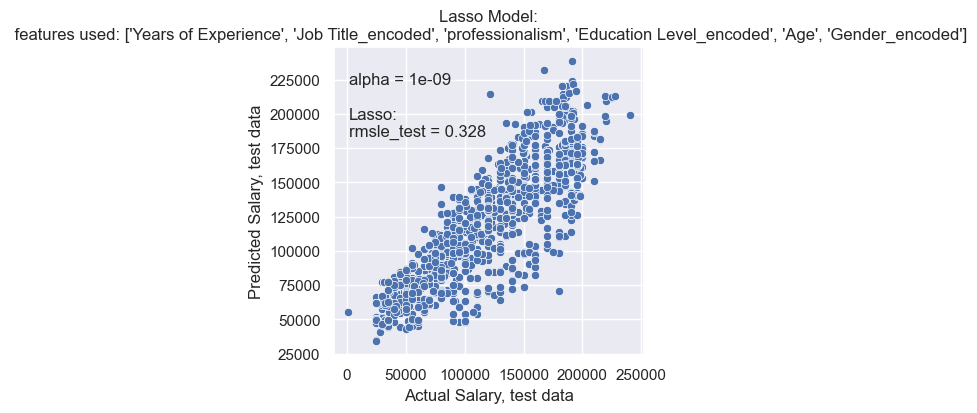

In [48]:
# Testing with Lasso/ridge Linear regression - when using only 'chosen_model_features'
# Nothing to write home about ###################################################################

# split the datasets to train and test
# X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

# define alphas to interate through
# alphas = [0.000001, 0.01, 0.1,1, 10,100, 1000,10000]
# alphas = [0.000001, 0.01, 0.1,1, 10,100, 10000, 100000, 1000000, 10000000]
alphas = [0.000000001]

from sklearn.linear_model import LinearRegression, Lasso, Ridge

for alpha in alphas:
  # print(alpha)
  # instantiate class object
  lasso = Lasso(alpha = alpha)
  ridge = Ridge(alpha = alpha)

  # fit
  # lasso.fit(X_train, y_train)
  # ridge.fit(X_train, y_train)
  lasso.fit(X_train[chosen_model_features], y_train)
  ridge.fit(X_train[chosen_model_features], y_train)

  # predict
  # y_pred_lasso_train = lasso.predict(X_train)
  # y_pred_ridge_train = ridge.predict(X_train)
  # y_pred_lasso_test = lasso.predict(X_test)
  # y_pred_ridge_test = ridge.predict(X_test)
  y_pred_lasso_train = lasso.predict(X_train[chosen_model_features])
  y_pred_ridge_train = ridge.predict(X_train[chosen_model_features])
  y_pred_lasso_test = lasso.predict(X_test[chosen_model_features])
  y_pred_ridge_test = ridge.predict(X_test[chosen_model_features])

  # score
  lasso_rmsle_train = rmsle(y_train, y_pred_lasso_train)
  ridge_rmsle_train = rmsle(y_train, y_pred_ridge_train)
  lasso_rmsle_test = rmsle(y_test, y_pred_lasso_test)
  ridge_rmsle_test = rmsle(y_test, y_pred_ridge_test)

  # print coeffiecients
  print(f'for alpha = {alpha}:')
  print(f"lasso rmsle train is {lasso_rmsle_train:.3f} and test rmsle is {lasso_rmsle_test:.3f}")
  print(f"ridge rmsle train is {ridge_rmsle_train:.3f} and test rmsle is {ridge_rmsle_test:.3f}\n")

  # plot
  fig, ax = plt.subplots()
  sns.scatterplot(x = y_test, y = y_pred_lasso_test, ax = ax, color = 'b')
  # sns.scatterplot(x = y_test, y = y_pred_ridge_test, ax = ax, color = 'g')
  ax.text(x=0.05, y=0.7, s= f'alpha = {alpha}\n\nLasso:\nrmsle_test = {lasso_rmsle_test:.3f}', fontsize=12, ha='left', va='bottom', transform=ax.transAxes)
  
  sns.set(rc={'figure.figsize':(4,4)})
  plt.title(f"Lasso Model:\n features used: {features}")
  plt.xlabel('Actual Salary, test data')
  plt.ylabel('Predicted Salary, test data')
  # plt.legend(loc = 'best')

  # print(f"and features {X_train[['Country_encoded','Race_encoded']].columns.values}:")
  # print(f"lasso coefficients are: {lasso.coef_}")
  # print(f"ridge coefficients are: {ridge.coef_}\n")

C:\Users\user\anaconda3\envs\eda\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.243e+11, tolerance: 1.050e+09
  model = cd_fast.enet_coordinate_descent(


for alpha = 1e-09:
lasso rmsle train is 0.315 and test rmsle is 0.328
ridge rmsle train is 0.315 and test rmsle is 0.328



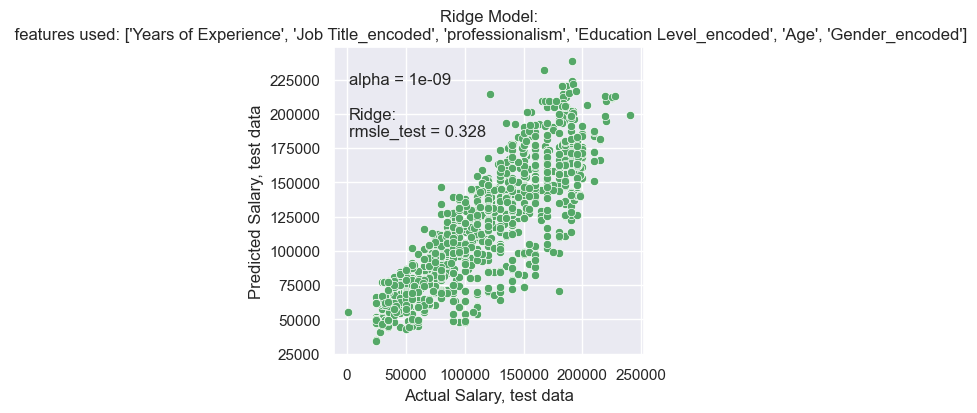

In [49]:
# Testing with Lasso/ridge Linear regression - when using only 'chosen_model_features'
# Nothing to write home about ###################################################################

# split the datasets to train and test
# X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.33, random_state=42)

# define alphas to interate through
# alphas = [0.000001, 0.01, 0.1,1, 10,100, 1000,10000]
# alphas = [0.000001, 0.01, 0.1,1, 10,100, 10000, 100000, 1000000, 10000000]
alphas = [0.000000001]

from sklearn.linear_model import LinearRegression, Lasso, Ridge

for alpha in alphas:
  # print(alpha)
  # instantiate class object
  lasso = Lasso(alpha = alpha)
  ridge = Ridge(alpha = alpha)

  # fit
  # lasso.fit(X_train, y_train)
  # ridge.fit(X_train, y_train)
  lasso.fit(X_train[chosen_model_features], y_train)
  ridge.fit(X_train[chosen_model_features], y_train)

  # predict
  # y_pred_lasso_train = lasso.predict(X_train)
  # y_pred_ridge_train = ridge.predict(X_train)
  # y_pred_lasso_test = lasso.predict(X_test)
  # y_pred_ridge_test = ridge.predict(X_test)
  y_pred_lasso_train = lasso.predict(X_train[chosen_model_features])
  y_pred_ridge_train = ridge.predict(X_train[chosen_model_features])
  y_pred_lasso_test = lasso.predict(X_test[chosen_model_features])
  y_pred_ridge_test = ridge.predict(X_test[chosen_model_features])

  # score
  lasso_rmsle_train = rmsle(y_train, y_pred_lasso_train)
  ridge_rmsle_train = rmsle(y_train, y_pred_ridge_train)
  lasso_rmsle_test = rmsle(y_test, y_pred_lasso_test)
  ridge_rmsle_test = rmsle(y_test, y_pred_ridge_test)

  # print coeffiecients
  print(f'for alpha = {alpha}:')
  print(f"lasso rmsle train is {lasso_rmsle_train:.3f} and test rmsle is {lasso_rmsle_test:.3f}")
  print(f"ridge rmsle train is {ridge_rmsle_train:.3f} and test rmsle is {ridge_rmsle_test:.3f}\n")

  # plot
  fig, ax = plt.subplots()
  # sns.scatterplot(x = y_test, y = y_pred_lasso_test, ax = ax, color = 'b')
  sns.scatterplot(x = y_test, y = y_pred_ridge_test, ax = ax, color = 'g')
  ax.text(x=0.05, y=0.7, s= f'alpha = {alpha}\n\nRidge:\nrmsle_test = {ridge_rmsle_test:.3f}', fontsize=12, ha='left', va='bottom', transform=ax.transAxes)
  
  sns.set(rc={'figure.figsize':(4,4)})
  plt.title(f"Ridge Model:\n features used: {features}")
  plt.xlabel('Actual Salary, test data')
  plt.ylabel('Predicted Salary, test data')
  # plt.legend(loc = 'best')

  # print(f"and features {X_train[['Country_encoded','Race_encoded']].columns.values}:")
  # print(f"lasso coefficients are: {lasso.coef_}")
  # print(f"ridge coefficients are: {ridge.coef_}\n")

C:\Users\user\AppData\Local\Temp\ipykernel_20184\1518264988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(X_train.columns.values.tolist()).ngroup()


Text(0, 0.5, 'Predicted Salary, test data')

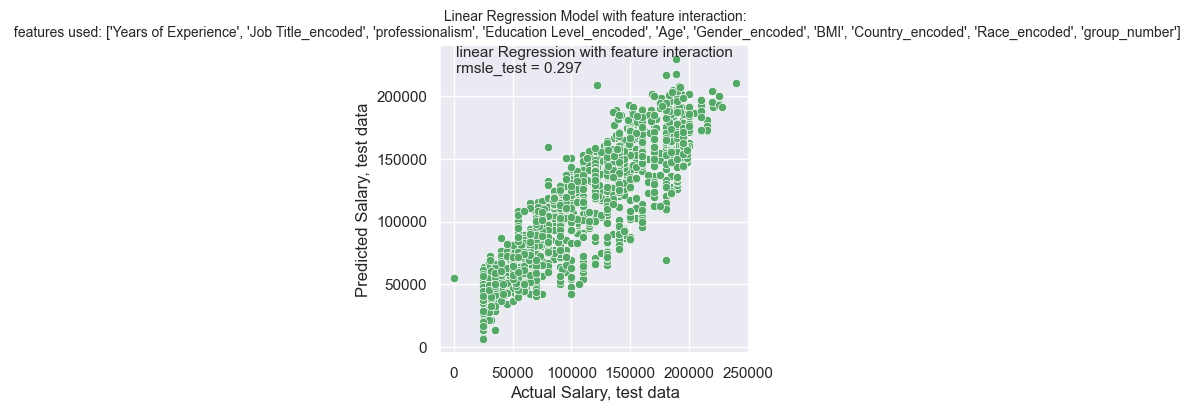

In [50]:
# testing how linear regression model behaves when given a feature interaction column
# X['group_number'] = X.groupby(chosen_model_features).ngroup()
X['group_number'] = X.groupby(X_train.columns.values.tolist()).ngroup()

lm = LinearRegression()

model = lm.fit(X_train,y_train)

y_pred = lm.predict(X_test)

lm_rmsle = rmsle(y_test,y_pred)

# plot
fig, ax = plt.subplots()
# sns.scatterplot(x = y_test, y = y_pred_lasso_test, ax = ax, color = 'b')
sns.scatterplot(x = y_test, y = y_pred, ax = ax, color = 'g')
ax.text(x=0.05, y=0.9, s= f'linear Regression with feature interaction\nrmsle_test = {lm_rmsle:.3f}', fontsize=11, ha='left', va='bottom', transform=ax.transAxes)
  
sns.set(rc={'figure.figsize':(4,4)})
plt.title(f"Linear Regression Model with feature interaction:\n features used: {X_train.columns.values.tolist()}", fontsize=10)
plt.xlabel('Actual Salary, test data')
plt.ylabel('Predicted Salary, test data')



C:\Users\user\AppData\Local\Temp\ipykernel_20184\4190308859.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['group_number'] = X.groupby(X_train.columns[:-1].values.tolist()).ngroup()


Text(0, 0.5, 'Predicted Salary, test data')

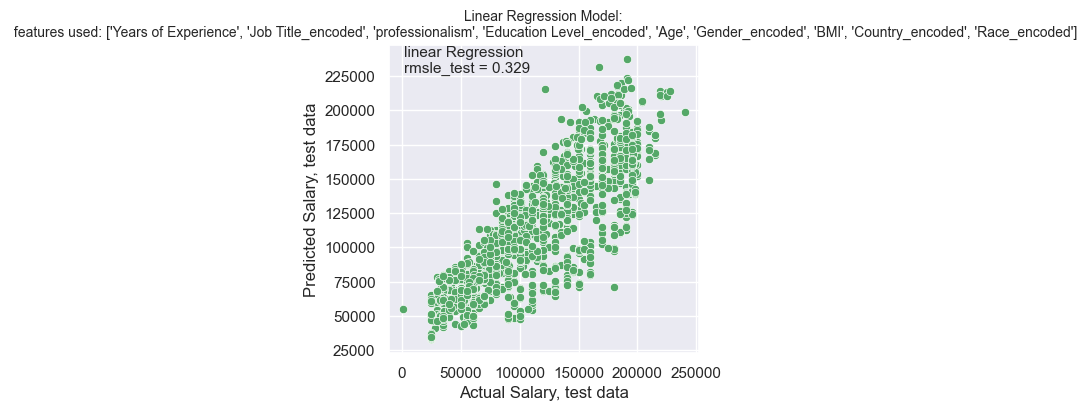

In [51]:
# testing how linear regression model behaves without the feature interaction column
# X['group_number'] = X.groupby(chosen_model_features).ngroup()
X['group_number'] = X.groupby(X_train.columns[:-1].values.tolist()).ngroup()

lm = LinearRegression()

model = lm.fit(X_train[X_train.columns[:-1]],y_train)

y_pred = lm.predict(X_test[X_test.columns[:-1]])

lm_rmsle = rmsle(y_test,y_pred)

# plot
fig, ax = plt.subplots()
# sns.scatterplot(x = y_test, y = y_pred_lasso_test, ax = ax, color = 'b')
sns.scatterplot(x = y_test, y = y_pred, ax = ax, color = 'g')
ax.text(x=0.05, y=0.9, s= f'linear Regression\nrmsle_test = {lm_rmsle:.3f}', fontsize=11, ha='left', va='bottom', transform=ax.transAxes)
  
sns.set(rc={'figure.figsize':(4,4)})
plt.title(f"Linear Regression Model:\n features used: {X_train.columns[:-1].values.tolist()}", fontsize=10)
plt.xlabel('Actual Salary, test data')
plt.ylabel('Predicted Salary, test data')

In [52]:
# Conclusion: including the 'group_by'-based 'group_number' column that conveys/reflects feature interaction to the model, 
# slightly improves the rmsle of the Linear Regression model: rmsle decreases from 0.329 to 0.297
# X_train[X_train.columns[:]]